<a href="https://colab.research.google.com/github/jemalmgr/AH2179/blob/main/Hand_In_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AH2179 Hand-In Assignment 4
## Use the neural network model for bus arrival delay prediction
By Jennifer Malmgren

### Setup

In [1]:
!pip install keras-tuner --upgrade

In [10]:
# Imports

import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
# Get the dataset

url = 'https://raw.githubusercontent.com/zhenliangma/Applied-AI-in-Transportation/master/Exercise_7_Neural_networks/Exercise7data.csv'
df = pd.read_csv(url)
df

,Arrival_time,Stop_id,Bus_id,Line_id,Arrival_delay,Dwell_time,Scheduled_travel_time,Upstream_stop_delay,Recurrent_delay
0,01/05/2022 07:06,10261,44417,3,69,0,82,33,99.925373
1,01/05/2022 07:20,10261,45544,3,35,0,82,52,100.191176
2,01/05/2022 07:35,10261,44410,3,7,0,82,10,99.681159
3,01/05/2022 07:51,10261,41724,3,74,15,82,27,99.385714
4,01/05/2022 20:16,10261,45544,3,-3,0,109,17,116.298507
...,...,...,...,...,...,...,...,...,...
4957,30/05/2022 22:02,10261,41734,4,32,0,120,28,161.900000
4958,31/05/2022 21:32,10261,41375,4,16,0,120,6,157.607692
4959,31/05/2022 21:43,10261,41373,4,69,0,120,59,157.396947
4960,31/05/2022 21:53,10261,41367,4,74,0,120,87,157.189394


### Data preparation

In [4]:
# Keep only the interesting data

df = df.drop(['Arrival_time', 'Stop_id', 'Bus_id', 'Line_id'], axis=1)
df

,Arrival_delay,Dwell_time,Scheduled_travel_time,Upstream_stop_delay,Recurrent_delay
0,69,0,82,33,99.925373
1,35,0,82,52,100.191176
2,7,0,82,10,99.681159
3,74,15,82,27,99.385714
4,-3,0,109,17,116.298507
...,...,...,...,...,...
4957,32,0,120,28,161.900000
4958,16,0,120,6,157.607692
4959,69,0,120,59,157.396947
4960,74,0,120,87,157.189394


In [5]:
# Create a train/test split

x = df.drop(['Arrival_delay'], axis=1)
y = df['Arrival_delay']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((3969, 4), (3969,)), ((993, 4), (993,)))

### Network construction

In [6]:
# Find optimal nn construction using keras tuner
# Recommended resources:
# https://keras.io/keras_tuner/
# https://www.youtube.com/watch?v=6Nf1x7qThR8

def build_model(hp):

  hp_l1_units = hp.Int('l1_units', min_value=16, max_value=64, step=8)
  hp_l1_droprate = hp.Choice('l1_droprate', values=[0.0, 0.2, 0.5])
  hp_l2_units = hp.Int('l2_units', min_value=8, max_value=32, step=8)
  hp_l2_droprate = hp.Choice('l2_droprate', values=[0.0, 0.2, 0.5])
  hp_activation = hp.Choice('activation', values=['linear', 'relu'])
  hp_lr = hp.Choice('lr', values=[0.01, 0.001])

  model = Sequential()
  model.add(Dense(hp_l1_units, activation=hp_activation, input_dim=4))
  model.add(Dropout(hp_l1_droprate))
  model.add(Dense(hp_l2_units, activation=hp_activation))
  model.add(Dropout(hp_l2_droprate))
  model.add(Dense(1))
  model.compile(optimizer=Adam(hp_lr), loss='mae', metrics=['mae'])

  return model

tuner = kt.Hyperband(build_model,
                     objective='val_mae',
                     max_epochs=50,
                     factor=3,
                     seed=42,
                     directory='my_dir',
                     project_name='arrival_delay')

early_stop = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=3)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32, callbacks=[early_stop, reduce_lr])

Trial 90 Complete [00h 00m 06s]
val_mae: 25.40001106262207

Best val_mae So Far: 25.18853759765625
Total elapsed time: 00h 07m 31s


In [7]:
# Make the best model

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32, callbacks=[early_stop, reduce_lr])

Epoch 1/50
100/100 [==============================] - 1s 5ms/step - loss: 33.4260 - mae: 33.4260 - val_loss: 30.4977 - val_mae: 30.4977 - lr: 0.0100
Epoch 2/50
100/100 [==============================] - 0s 4ms/step - loss: 28.1649 - mae: 28.1649 - val_loss: 27.4303 - val_mae: 27.4303 - lr: 0.0100
Epoch 3/50
100/100 [==============================] - 0s 4ms/step - loss: 28.2007 - mae: 28.2007 - val_loss: 27.6056 - val_mae: 27.6056 - lr: 0.0100
Epoch 4/50
100/100 [==============================] - 0s 4ms/step - loss: 28.2635 - mae: 28.2635 - val_loss: 27.4124 - val_mae: 27.4124 - lr: 0.0100
Epoch 5/50
100/100 [==============================] - 0s 4ms/step - loss: 28.7548 - mae: 28.7548 - val_loss: 27.4617 - val_mae: 27.4617 - lr: 0.0100
Epoch 6/50
100/100 [==============================] - 0s 4ms/step - loss: 27.5601 - mae: 27.5601 - val_loss: 27.7092 - val_mae: 27.7092 - lr: 0.0100
Epoch 7/50
100/100 [==============================] - 0s 4ms/step - loss: 28.1390 - mae: 28.1390 - val_los

In [8]:
# Check the history

pd.DataFrame(history.history)

,loss,mae,val_loss,val_mae,lr
0,33.425957,33.425957,30.497683,30.497683,0.010
1,28.164900,28.164900,27.430258,27.430258,0.010
2,28.200663,28.200663,27.605568,27.605568,0.010
3,28.263451,28.263451,27.412401,27.412401,0.010
4,28.754803,28.754803,27.461702,27.461702,0.010
5,27.560110,27.560110,27.709183,27.709183,0.010
6,28.139048,28.139048,25.991539,25.991541,0.010
7,27.275776,27.275776,25.339399,25.339399,0.010
8,27.665499,27.665499,27.157263,27.157263,0.010
9,27.606009,27.606009,25.779825,25.779825,0.010


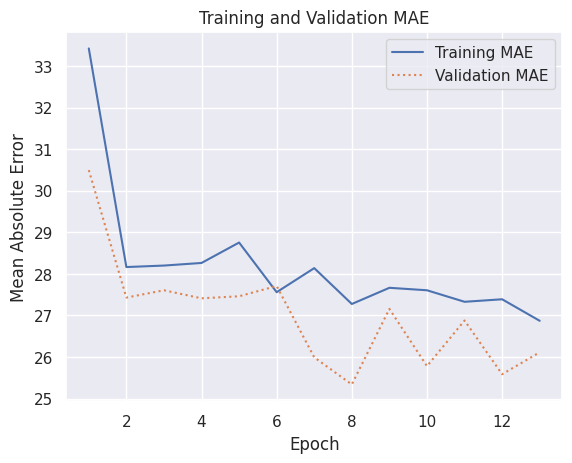

In [11]:
# Plot the training and validation MAE

sns.set()

err = history.history['mae']
val_err = history.history['val_mae']
epochs = range(1, len(err) + 1)

plt.plot(epochs, err, '-', label='Training MAE')
plt.plot(epochs, val_err, ':', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='upper right')
plt.show()

In [12]:
# Evaluate the best model

y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('--------------------------------------This is result of the best model---------------------------------------------')
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

32/32 [==============================] - 0s 2ms/step
--------------------------------------This is result of the best model---------------------------------------------
Mean Absolute Error: 27.959314069268927
Mean Squared Error: 1377.9567692637713
R-squared: 0.9095876194782712
